<a href="https://colab.research.google.com/github/HannahanX/TweetClassification_Trump-or-Biden/blob/main/TweetClassification_Trump_or_Biden%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN Text: Tweet Classification
**Deep Learning - University of Connecticut**

Full Name: Hang Xu


-----------------------------------------------
As I learned text classification, I am interested in classifying a real-world problem.
In this project, I use the function to scrape 2000 tweets for two people I am interested in. Then save these tweets to my drive as text files with two folders.


# Introduction

The idea comes from the latest news, saying that Twitter will transfer the `@POTUS` account to Presidential-elected Biden even if President Donald Trump hasn’t conceded. Other presidential account on Twitter includes `@whitehouse`, `@VP` and `@FLOTUS`, being moved as well.

Since the two presidential nominees are two of the most active accounts on Twitter, they won the highest public attention all over the world. The models I developed are aimed at those two presidential candidates, the biggest figures in the past year, trying to predict individuals or organizations political preference and capture the implicit bias through their Twitter accounts

`@realDonaldTrump`: the 45th and current president of the United States. Before entering politics, Donald Trump was a businessman and television personality.

`@JoeBiden`: the 47th vice president during the Obama administration. Joe Biden defeated incumbent president Donald Trump in the 2020 United States presidential election and will be inaugurated as the 46th president on January 20, 2021.

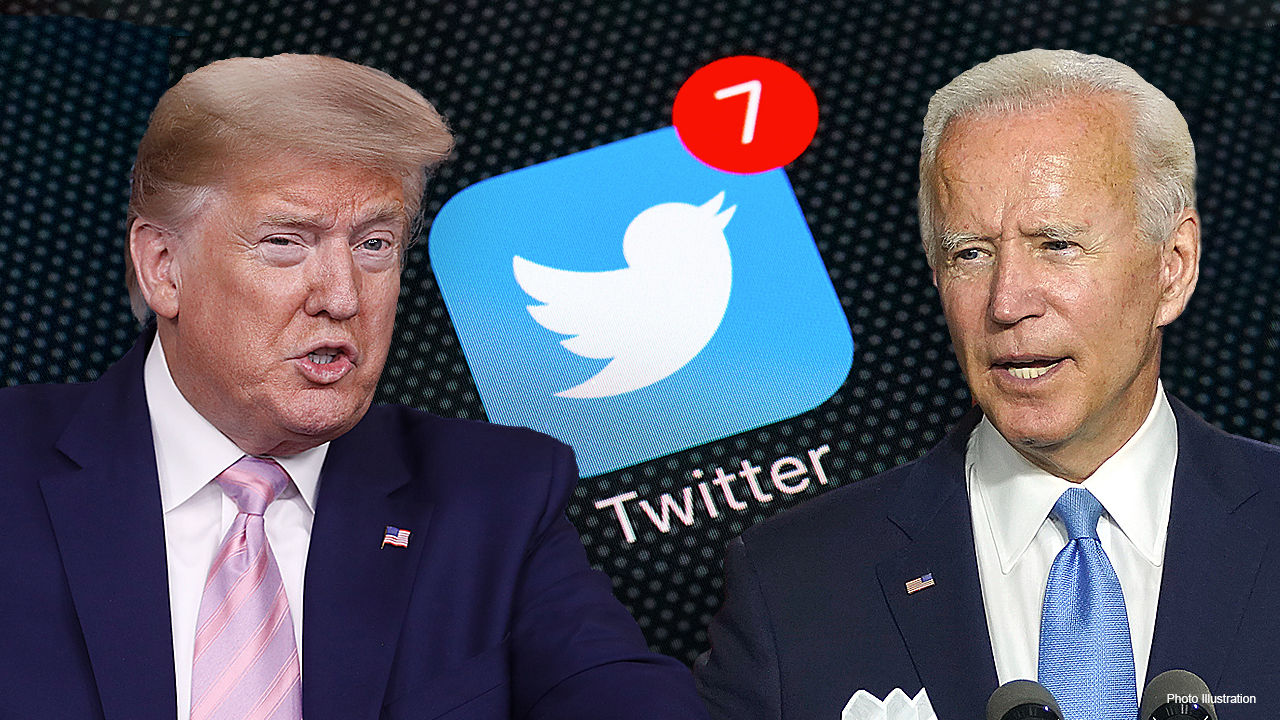


# Part I: Data Preparation


[Click here: Trump and Biden Tweets](https://drive.google.com/drive/folders/1WEpgsYSHVyHT2sqxoTyna1DG-XURFkzq?usp=sharing)



In [ ]:
# mount your drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Scrape tweets and save as csv files

In [ ]:
# make a folder to store data
base_dir = '/content/drive/MyDrive/Semester3/OPIM 5509 Deep Learning/Module 5: Recurrent Neural Networks for Text Sequences  /Module 5.2 - Implementation and Advanced Topics  /data5'

import tensorflow as tf

#Create a new directory (a folder) in your Drive
tf.io.gfile.mkdir(base_dir)

#Combine the 2 strings
trump_dir = base_dir + '/trump/'
biden_dir = base_dir + '/biden/'

#Create the second directory
tf.io.gfile.mkdir(trump_dir)
tf.io.gfile.mkdir(biden_dir)

In [ ]:
!pip install snscrape
import snscrape.modules.twitter as sntwitter
import csv

In [ ]:
maxTweets = 2000

# make sure you update the username and number of tweets!
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('from:@realDonaldTrump + since:2015-12-02 until:2020-11-05-filter:links -filter:replies').get_items()):
  csvFile = open(trump_dir + str(i) + '.csv', 'a', newline='', encoding='utf8')
  csvWriter = csv.writer(csvFile)
  csvWriter.writerow(['id','date','tweet',])

  if i > maxTweets :
    break
  csvWriter.writerow([tweet.id, tweet.date, tweet.content])
csvFile.close()

In [ ]:
maxTweets = 2000

# make sure you update the username and number of tweets!
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('from:@JoeBiden + since:2015-12-02 until:2020-11-05-filter:links -filter:replies').get_items()):
  csvFile = open(biden_dir + str(i) + '.csv', 'a', newline='', encoding='utf8')
  csvWriter = csv.writer(csvFile)
  csvWriter.writerow(['id','date','tweet',])

  if i > maxTweets :
    break
  csvWriter.writerow([tweet.id, tweet.date, tweet.content])
csvFile.close()

## Loading data and prepare data for modeling

In [1]:
#Load the data you just saved from your drive
#import os

#my_dir = base_dir

#labels = []
#texts = []
#count = 0
#for label_type in ['biden/', 'trump/']:
#    dir_name = os.path.join(my_dir, label_type)
#    for fname in os.listdir(dir_name):
#        if fname[-4:] == '.csv':
#            count = count + 1
#           print(count)
#            f = open(os.path.join(dir_name, fname))
#           texts.append(f.read())
#            f.close()
#            if label_type == 'biden/':
 #               labels.append(0)
  #          else:
   #             labels.append(1)

## Tokenize, pad the sequences and split data to training and validation.

In [ ]:
# Tokenize, pad and prepare training and validation data
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 50 # or 200
validation_samples = 1000  # We will be validating on 1000 samples
max_words = 1000  # We will only consider the top 1000 words in the dataset

tokenizer = Tokenizer(num_words=max_words)

# fit_on_texts means it learns the indices of the words
tokenizer.fit_on_texts(texts)

# the sequences are comprised of those indices
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# in case of low word counts, we need to pad sequences
# so that they are uniform length
data = pad_sequences(sequences, maxlen=maxlen)

# our labels, which were previously stored as a list [],
# are now converted to a numpy array for modeling
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 14247 unique tokens.
Shape of data tensor: (4004, 50)
Shape of label tensor: (4004,)


In [ ]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

training_samples = 3000  # We will be training on 3000 samples

x_train = data[:training_samples] # from 0 to training samples
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [ ]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(3000, 50) (3000,)
(1000, 50) (1000,)


# Part II: Modeling

## Pre-process the embeddings

In [ ]:
import numpy as np

# this loads very quickly

# there is a slash at the end!
glove_dir = '/content/drive/MyDrive/Semester3/OPIM 5509 Deep Learning/Module 5: Recurrent Neural Networks for Text Sequences  /Module 5.2 - Implementation and Advanced Topics  /glove.6B/'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
embedding_dim = 100 # this is the dimension of the file we imported
# make sure you are consistent! if you imported the 50 dim GLOVE, make it 50!

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

## GRU and LSTM

### Model - GRU and LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM
from keras.layers import LSTM, Dropout, GRU 

model = Sequential() 
model.add(Embedding(max_words, 100, input_length=maxlen)) 
model.add(LSTM(64, return_sequences=True, activation='relu', recurrent_dropout=0.2)) 
model.add(GRU(32, activation='relu', recurrent_dropout=0.2)) 
model.add(Dropout(0.2)) 
model.add(Dense(1, activation='sigmoid')) 
model.summary() 

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 50, 100)           100000    
_________________________________________________________________
lstm_18 (LSTM)               (None, 50, 64)            42240     
_________________________________________________________________
gru_13 (GRU)                 (None, 32)                9408      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 151,681
Trainable params: 151,681
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Load the GloVe embeddings in the model
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False # freezes everything

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
300/300 [==============================] - 20s 67ms/step - loss: 0.4796 - acc: 0.7890 - val_loss: 0.3026 - val_acc: 0.8770
Epoch 2/10
300/300 [==============================] - 20s 65ms/step - loss: 0.2691 - acc: 0.9087 - val_loss: 0.2766 - val_acc: 0.9140
Epoch 3/10
300/300 [==============================] - 20s 66ms/step - loss: 0.1682 - acc: 0.9373 - val_loss: 0.1343 - val_acc: 0.9490
Epoch 4/10
300/300 [==============================] - 20s 66ms/step - loss: 0.1266 - acc: 0.9543 - val_loss: 0.1198 - val_acc: 0.9570
Epoch 5/10
300/300 [==============================] - 20s 67ms/step - loss: 0.1009 - acc: 0.9640 - val_loss: 0.1087 - val_acc: 0.9620
Epoch 6/10
300/300 [==============================] - 20s 65ms/step - loss: 0.0937 - acc: 0.9683 - val_loss: 0.1382 - val_acc: 0.9580
Epoch 7/10
300/300 [==============================] - 20s 65ms/step - loss: 0.0834 - acc: 0.9730 - val_loss: 0.1025 - val_acc: 0.9630
Epoch 8/10
300/300 [==============================] - 20s 65ms

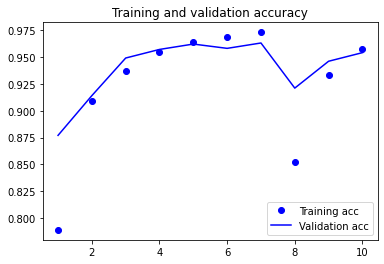

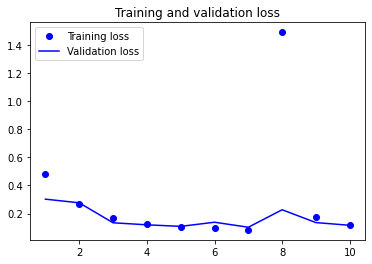

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Confusion matrix with report

In [ ]:
# classification error metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#predict the validation results 
preds = np.round(model.predict(x_val),0)

#Evaluating the model

tn, fp, fn, tp = confusion_matrix(y_val, preds).ravel()
tn, fp, fn, tp

(480, 28, 18, 474)

In [ ]:
#Classification report 
report = classification_report(y_val, preds)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       508
           1       0.94      0.96      0.95       492

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



## Simple GRU

### Model2 - GRU

In [ ]:
from tensorflow.keras.layers import GRU

model = Sequential()
model.add(Embedding(max_words, 100, input_length=maxlen))
model.add(GRU(64, dropout=0.1, recurrent_dropout=0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Load the GloVe embeddings in the model
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False # freezes everything

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
300/300 [==============================] - 14s 46ms/step - loss: 0.4768 - acc: 0.7583 - val_loss: 0.2098 - val_acc: 0.9230
Epoch 2/10
300/300 [==============================] - 15s 48ms/step - loss: 0.1846 - acc: 0.9290 - val_loss: 0.1443 - val_acc: 0.9480
Epoch 3/10
300/300 [==============================] - 14s 47ms/step - loss: 0.1433 - acc: 0.9473 - val_loss: 0.1555 - val_acc: 0.9460
Epoch 4/10
300/300 [==============================] - 13s 45ms/step - loss: 0.0985 - acc: 0.9657 - val_loss: 0.1259 - val_acc: 0.9640
Epoch 5/10
300/300 [==============================] - 14s 45ms/step - loss: 0.0829 - acc: 0.9730 - val_loss: 0.0841 - val_acc: 0.9700
Epoch 6/10
300/300 [==============================] - 14s 45ms/step - loss: 0.0737 - acc: 0.9750 - val_loss: 0.1108 - val_acc: 0.9670
Epoch 7/10
300/300 [==============================] - 14s 45ms/step - loss: 0.0566 - acc: 0.9820 - val_loss: 0.1459 - val_acc: 0.9570
Epoch 8/10
300/300 [==============================] - 14s 46ms

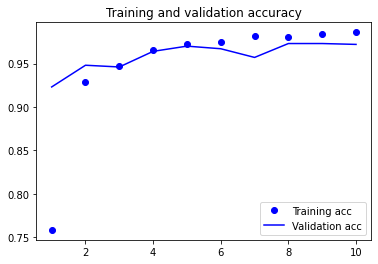

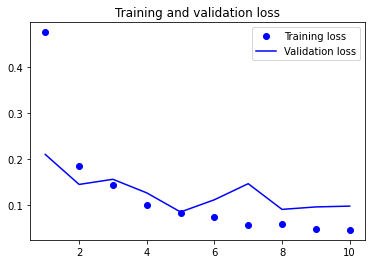

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Confusion matrix with report

In [ ]:
# classification error metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#predict the validation results 
preds = np.round(model.predict(x_val),0)

In [ ]:
#Evaluating the model

tn, fp, fn, tp = confusion_matrix(y_val, preds).ravel()
tn, fp, fn, tp

(497, 11, 17, 475)

In [ ]:
#Classification report 
report = classification_report(y_val, preds)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       508
           1       0.98      0.97      0.97       492

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



## Bidirectional LSTM, Conv1D, Maxpooling


### Model3 - Bidirectional LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM
from keras.layers import Dense, SimpleRNN, LSTM, Dropout, Bidirectional, Conv1D, MaxPooling1D

model = Sequential()
model.add(Embedding(max_words, 100, input_length=maxlen))
model.add(Conv1D(filters=20, kernel_size=2)) 
model.add(MaxPooling1D(2))
model.add(Bidirectional(LSTM(30, activation='relu', return_sequences=True)))
model.add(GRU(40, activation='relu', return_sequences=True))
model.add(Bidirectional(LSTM(10, activation='relu')))
model.add(Dropout(0.1)) # pick a number between 0.1 and 0.3
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=['mae'])
model.summary()

# Load the GloVe embeddings in the model
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False # freezes everything

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 50, 100)           100000    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 49, 20)            4020      
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 24, 20)            0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 24, 60)            12240     
_________________________________________________________________
gru_14 (GRU)                 (None, 24, 40)            12240     
_________________________________________________________________
bidirectional_8 (Bidirection (None, 20)                4080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 20)              

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
300/300 [==============================] - 9s 31ms/step - loss: 0.8158 - acc: 0.6357 - val_loss: 0.5632 - val_acc: 0.7710
Epoch 2/10
300/300 [==============================] - 8s 28ms/step - loss: 0.7039 - acc: 0.6853 - val_loss: 0.3914 - val_acc: 0.8800
Epoch 3/10
300/300 [==============================] - 8s 28ms/step - loss: 0.4246 - acc: 0.8250 - val_loss: 0.3233 - val_acc: 0.8880
Epoch 4/10
300/300 [==============================] - 8s 28ms/step - loss: 0.4148 - acc: 0.8837 - val_loss: 0.3318 - val_acc: 0.8970
Epoch 5/10
300/300 [==============================] - 8s 28ms/step - loss: 1.5256 - acc: 0.7010 - val_loss: 0.6890 - val_acc: 0.6220
Epoch 6/10
300/300 [==============================] - 8s 28ms/step - loss: 0.6109 - acc: 0.6673 - val_loss: 0.4998 - val_acc: 0.7840
Epoch 7/10
300/300 [==============================] - 9s 28ms/step - loss: 0.6966 - acc: 0.7683 - val_loss: 0.4696 - val_acc: 0.7680
Epoch 8/10
300/300 [==============================] - 9s 28ms/step - 

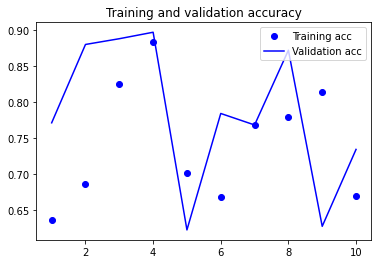

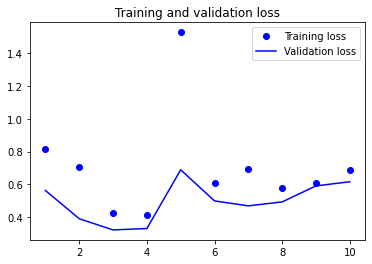

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Confusion matrix with report

In [ ]:
# classification error metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#predict the validation results 
preds = np.round(model.predict(x_val),0)

In [ ]:
#Evaluating the model

tn, fp, fn, tp = confusion_matrix(y_val, preds).ravel()
tn, fp, fn, tp

(431, 77, 189, 303)

In [ ]:
#Classification report 
report = classification_report(y_val, preds)
print(report)

              precision    recall  f1-score   support

           0       0.70      0.85      0.76       508
           1       0.80      0.62      0.69       492

    accuracy                           0.73      1000
   macro avg       0.75      0.73      0.73      1000
weighted avg       0.75      0.73      0.73      1000



# Part III: Analysis

## Find top 50 words for each person

In [ ]:
labels_ = []
texts_ = []
count = 0
for label_type in ['biden/', 'trump/']:
    dir_name = os.path.join(my_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.csv':
            count = count + 1
            f = open(os.path.join(dir_name, fname))
            texts_.append(f.read())
            f.close()
            if label_type == 'biden/':
                labels_.append('biden')
            else:
                labels_.append('trump')

In [ ]:
import pandas as pd
dic={'Label':labels_,'Text':texts_}
df=pd.DataFrame(dic)
df_biden=df[df.Label=='biden']
df_trump=df[df.Label=='trump']

In [ ]:
a=pd.Series(' '.join(df_biden.Text).split()).value_counts()[:50]
b=pd.Series(' '.join(df_trump.Text).split()).value_counts()[:50]

In [ ]:
a_=pd.DataFrame(a,columns=['biden'])
b_=pd.DataFrame(b,columns=['trump'])

In [ ]:
c=pd.concat([a_,b_],axis=1,join='outer',ignore_index=False)
c.info()

<class 'pandas.core.frame.DataFrame'>
Index: 66 entries, to to going
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   biden   50 non-null     float64
 1   trump   50 non-null     float64
dtypes: float64(2)
memory usage: 1.5+ KB


In [ ]:
# biden
a_

,biden
to,2318
the,2245
"id,date,tweet",2002
and,1757
of,1101
a,1049
in,883
—,671
for,668
is,636


In [ ]:
# trump common words
b_

,trump
"id,date,tweet",2002
the,1266
and,996
to,880
of,614
a,573
in,488
for,461
is,460
will,369


## Results comparation and model improvement

*   The first model I develped combined the LSTM and GRU with a 0.2 dropout layer, it gave an accuracy of 95%. And the training and validation fit good, but there is a quick drop during the 8th epoch.
*   The simple GRU model also includes embeddings as the first model, but I dumped the LSTM and just kept one GRU in the model. The simpler model even performed better, coming up with a 97% accuracy. The training and validation plots are stable after 3th epoch. So, this model is the best model I selected.
*   Even though the third model has a fancy architecture, including conv1D, Maxpooling, bidirectional LSTM and GRU, the model fits worse than previous two models, and the training and validation accuracy is not stable.
*   Recurrent neural network model gave us a higher accuracy than simple dense layer because it keeps tracking on the sequences from beginning to the end. It will look at the overall aspects of the data, taking into account the context of all those words.
*   Embedding is used for making every single word being explained in a particular dimensions.
*   Although I have a good accuracy of the model, I still need to further improve my model. Since according to the Common Words in the last session, there are some words not having exact meaning. 
*   The way I want improve my model is to add 'Stop words'. `Stop words` are simply common words in the English language - they are not special and generally don't convey too much information. So it's best to get rid of them.
*   Besides that, Lexicon Normalization is also a way to improve this model. It is a method to take the words in some standardized version, simplying the information.
